In [2]:
#This is based on:
# https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8759878
#codebase is from:
# https://www.kaggle.com/code/christianlillelund/classify-mnist-audio-using-spectrograms-keras-cnn/notebook

In [3]:
import csv
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import scipy as sp
import tensorflow as tf
import os
import sys

In [19]:
#load a testsample
data = sio.loadmat('training/'+'train_ecg_00097'+'.mat')
signal = data['val'].T
print(signal.shape)
signal = np.ravel(signal)
print(signal.shape)
#plt.plot(signal) 
#plt.show()

(9000, 1)
(9000,)


In [20]:
fs = 300

The start and end index are:  900 8100
The new length of the signal is:  7200


<function matplotlib.pyplot.show(close=None, block=None)>

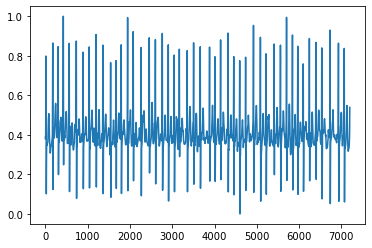

In [21]:
#cutoff the first and last 3 seconds of the signal
startindex = fs * 3 #seconds
endindex = signal.size - startindex
print("The start and end index are: ",startindex, endindex)
cutsignal = signal[startindex:endindex]
print("The new length of the signal is: ",cutsignal.size)

#normalise signalvalues
normalisesignal = (cutsignal - np.min(cutsignal)) / (np.max(cutsignal) - np.min(cutsignal))

#plot the cut and normalised signal
plt.plot(normalisesignal)
plt.show

(257, 32)

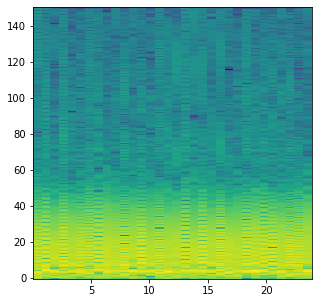

In [23]:
from scipy import signal as siglib
from scipy.fft import fftshift
np.set_printoptions(threshold=sys.maxsize)
#create spectogram of signal
#spectrum, freqs, t, im = plt.specgram(normalisesignal, NFFT=512, Fs=300, norm)

#plt.savefig('testfig.png')
plt.figure(figsize=(5,5))
f,t, Sxx = siglib.spectrogram(normalisesignal, fs=300, nfft=512)


plt.pcolor(t, f, 10*np.log10(Sxx))
Sxx.shape

In [208]:
os.remove('Preproces/N.npy')
os.remove('Preproces/A.npy')

with open('training/REFERENCE.csv') as csv_file:      # Einlesen der Liste mit Dateinamen und Zuordnung
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        data = sio.loadmat('training/'+row[0]+'.mat')   # Import der EKG-Dateien
        signal = data['val'].T
        signal = np.ravel(signal)
        cutsignal = signal.copy()
        #print(cutsignal.shape)
        cutsignal.resize(9000,)
        normalisesignal = (cutsignal - np.min(cutsignal)) / (np.max(cutsignal) - np.min(cutsignal))
       # Sxx, f, t, im = plt.specgram(normalisesignal, NFFT=512, Fs=300, xextent=(0,30))
        f,t, Sxx = siglib.spectrogram(normalisesignal, fs=300, nfft=512)
        Sxx = 10*np.log10(Sxx+1e-12)
        Sxx = np.reshape(Sxx, (Sxx.shape[0],Sxx.shape[1],1))
        
        if row[1]=='N':                        # Zuordnung zu "Normal"
            if os.path.exists('Preproces/N.npy'):
                Narr=np.load('Preproces/N.npy')
                Narr=np.concatenate((Narr,Sxx), axis=-1)
                #print(Narr.shape)
                np.save('Preproces/N.npy', Narr) 
            else:
                np.save('Preproces/N.npy', Sxx)
       
        if row[1]=='A':                        # Zuordnung zu "Vorhofflimmern"
            if os.path.exists('Preproces/A.npy'):
                Aarr=np.load('Preproces/A.npy')
                Aarr=np.concatenate((Aarr,Sxx), axis=-1)
                np.save('Preproces/A.npy', Aarr) 
            else:
                np.save('Preproces/A.npy', Sxx)            
        
        del data, signal, cutsignal, normalisesignal, Sxx, f,t
        
        line_count = line_count + 1
        if (line_count % 100)==0:
            print(str(line_count) + "\t Dateien wurden verarbeitet.")

100	 Dateien wurden verarbeitet.
200	 Dateien wurden verarbeitet.
300	 Dateien wurden verarbeitet.
400	 Dateien wurden verarbeitet.
500	 Dateien wurden verarbeitet.
600	 Dateien wurden verarbeitet.
700	 Dateien wurden verarbeitet.
800	 Dateien wurden verarbeitet.
900	 Dateien wurden verarbeitet.
1000	 Dateien wurden verarbeitet.
1100	 Dateien wurden verarbeitet.
1200	 Dateien wurden verarbeitet.
1300	 Dateien wurden verarbeitet.
1400	 Dateien wurden verarbeitet.
1500	 Dateien wurden verarbeitet.
1600	 Dateien wurden verarbeitet.
1700	 Dateien wurden verarbeitet.
1800	 Dateien wurden verarbeitet.
1900	 Dateien wurden verarbeitet.
2000	 Dateien wurden verarbeitet.
2100	 Dateien wurden verarbeitet.
2200	 Dateien wurden verarbeitet.
2300	 Dateien wurden verarbeitet.
2400	 Dateien wurden verarbeitet.
2500	 Dateien wurden verarbeitet.
2600	 Dateien wurden verarbeitet.
2700	 Dateien wurden verarbeitet.
2800	 Dateien wurden verarbeitet.
2900	 Dateien wurden verarbeitet.
3000	 Dateien wurden ve

In [209]:
Nclass = np.load('Preproces/N.npy')
Aclass = np.load('Preproces/A.npy')
print(Nclass.shape)
print(Aclass.shape)

(257, 40, 3581)
(257, 40, 521)


In [210]:
Nlabel=np.concatenate((np.expand_dims(np.ones((Nclass.shape[2],)), axis=-1),np.expand_dims(np.zeros((Nclass.shape[2],)), axis=-1)), axis=-1)
print(Nlabel.shape)
Alabel=np.concatenate((np.expand_dims(np.zeros((Aclass.shape[2],)), axis=-1),np.expand_dims(np.ones((Aclass.shape[2],)), axis=-1)), axis=-1)
print(Alabel.shape)
print(Nclass[:,:,1].shape)

(3581, 2)
(521, 2)
(257, 40)


In [212]:
import random
X = np.concatenate((Nclass,Aclass),axis=-1)
X=np.reshape(X,(-1,257,40))
print(X.shape)
Y = np.concatenate((Nlabel,Alabel),axis=0)
Y=Y
print(Y.shape)
mixed=list(zip(X,Y))
random.shuffle(mixed)
mixed=list(zip(*mixed))
X_train = np.asarray(mixed[0][0:int(0.8*len(mixed[0]))])
Y_train = np.asarray(mixed[1][0:int(0.8*len(mixed[1]))])
X_valid = np.asarray(mixed[0][int(0.8*len(mixed[0])):-1])
Y_valid = np.asarray(mixed[1][int(0.8*len(mixed[1])):-1])
X_train = np.expand_dims(X_train, -1)
X_valid = np.expand_dims(X_valid, -1)

print(X_train.shape)
print(X_valid.shape)
print(Y_train.shape)
print(Y_valid.shape)

print(len(np.where(np.isinf(X_train))))

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))
print(X_train.shape[1::])

train_dataset = train_dataset.batch(32)
valid_dataset = valid_dataset.batch(32)

(4102, 257, 40)
(4102, 2)
(3281, 257, 40, 1)
(820, 257, 40, 1)
(3281, 2)
(820, 2)
4
(257, 40, 1)


[1. 0.]


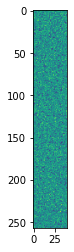

In [213]:
for images, labels in train_dataset.take(1):  # only take first element of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    print(numpy_labels[1])
    plt.imshow(numpy_images[1])

In [214]:
model.layers[-1].output[0]

<KerasTensor: shape=(2,) dtype=float32 (created by layer 'tf.__operators__.getitem_4')>

In [215]:
# Create CNN model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=X_train.shape[1::]))
model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(50, activation='relu'))
#model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


Epoch 1/3
103/103 [==============================] - 13s 125ms/step - loss: 1.1366 - accuracy: 0.8555 - val_loss: 0.3261 - val_accuracy: 0.8732
Epoch 2/3
103/103 [==============================] - 13s 122ms/step - loss: 0.3439 - accuracy: 0.8729 - val_loss: 0.3050 - val_accuracy: 0.8732
Epoch 3/3
103/103 [==============================] - 13s 124ms/step - loss: 0.3226 - accuracy: 0.8729 - val_loss: 0.2881 - val_accuracy: 0.8732


In [218]:

# Train model for 10 epochs, capture the history
history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset, shuffle=True)

Epoch 1/10
103/103 [==============================] - 12s 120ms/step - loss: 0.3789 - accuracy: 0.8729 - val_loss: 0.3736 - val_accuracy: 0.8732
Epoch 2/10
103/103 [==============================] - 12s 121ms/step - loss: 0.3585 - accuracy: 0.8729 - val_loss: 0.3336 - val_accuracy: 0.8732
Epoch 3/10
103/103 [==============================] - 12s 120ms/step - loss: 0.3448 - accuracy: 0.8729 - val_loss: 0.3388 - val_accuracy: 0.8732
Epoch 4/10
103/103 [==============================] - 13s 126ms/step - loss: 0.3245 - accuracy: 0.8729 - val_loss: 0.3940 - val_accuracy: 0.8732
Epoch 5/10
103/103 [==============================] - 13s 126ms/step - loss: 0.3891 - accuracy: 0.8729 - val_loss: 0.3412 - val_accuracy: 0.8732
Epoch 6/10
103/103 [==============================] - 18s 176ms/step - loss: 0.3810 - accuracy: 0.8729 - val_loss: 0.3875 - val_accuracy: 0.8732
Epoch 7/10
103/103 [==============================] - 14s 140ms/step - loss: 0.3931 - accuracy: 0.8729 - val_loss: 0.3895 - val_ac

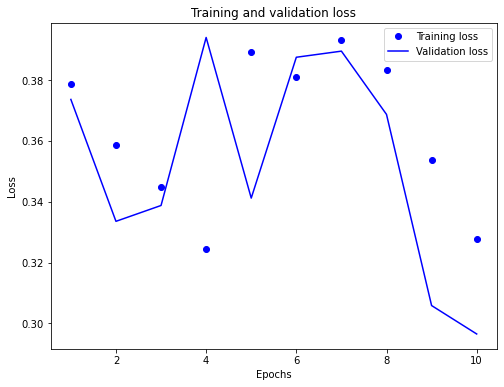

In [219]:
# Plot the loss curves for training and validation.
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

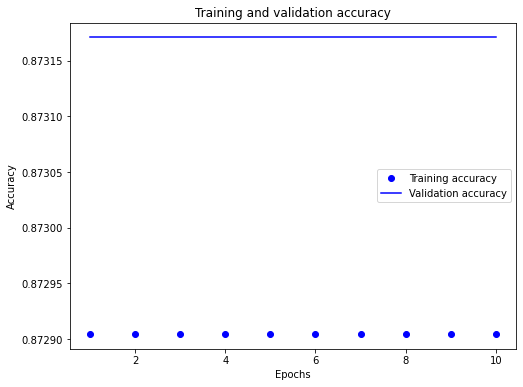

In [220]:
# Plot the accuracy curves for training and validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()